<a href="https://colab.research.google.com/github/AleCongi/Esame-ICON-/blob/main/Copia_di_postLitiiiigio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ingegneria della Conoscenza
Università degli studi di Bari "Aldo Moro", Dipartimento di Informatica.

Il seguente notebook è stato elaborato degli studenti:


*   Congedo Alessandro (mat. 677315)
*   Romano Andrea (mat. XXXXXX)

Il progetto che presentiamo è un esempio di come l'IA possa essere utilizzata per classificare eventi in base a descrizioni e categorie.

---



L'obiettivo di questo studio è quello di sviluppare un sistema di apprendimento automatico che sia in grado di rappresentare la conoscenza sia a basso livello che ad alto livello, garantendo una gestione d'incertezza.

Il progetto è stato condotto nell'ottica di arricchire il precedente lavoro dei [**BroUsers**](https://www.instagram.com/bro__users) chiamato [**OneNight**](https://t.me/wannight_bot), un **bot Telegram** che raccoglie informazioni sugli eventi in una determinata zona geografica.

---
L'esigenza di una filtrazione ulteriore degli eventi mediante delle categorie prestabilite si configura come una nuova espansione del progetto.

La passione che abbiamo per il nostro lavoro, sia quello sviluppato in passato che quello presentato, ci ha spinto a esplorare nuove soluzioni e a sviluppare un sistema che possa fornire un contributo significativo alla comunità.

**Indice delle sezioni:**


*   **A**: *CARICAMENTO E FIX DEL DATASET*
  * **A1**: *PLOT DEL DATASET*
*   **B**: *PREPROCESS DELLE DESCRIZIONI*
  * **B1**: *FUNZIONI PREPROCESSING*
  * **B2**: *PREPROCESSING*
  * **B3**: *TOKENIZATION, SEQUENCING & PADDING*
  * **B4**: *RAPPRESENTAZIONE DEL TESTO A BASSO LIVELLO*
      * **B4.1** *ALTERNATIVA EMBEDDINGS VIA WORLD2VEC*
      * **B4.2** *ALTERNATIVA FEATURE EXTRACTION VIA RETE NEURALE*
      * **B4.3** *ALTERNATIVA VECTORIZATION VIA TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY*
*   **C**: *CLASSIFICAZIONE*
*   **D**: *RETE NEURALE*
*   **E**: *LOGICHE FUZZY*
*   **F**: *RAPPRESENTAZIONE DELLA CONOSCENZA*
  * **F1**: *ONTOLOGIA: WORDNET*
  * **F2**: *RETE SEMANTICA*



In [3]:
!pip install nltk
!pip install scikit-multilearn
!pip install scikit-fuzzy
!pip install fuzzywuzzy
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 3.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=2718d022c1dde179d41bdbf10a97e60ed6bab60da3e3ac02bf9a51048b03e391
  Stored in directory: /root/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from google.colab import drive

import pandas as pd

import seaborn as sns

from re import sub as sub

import matplotlib.pyplot as plt

import string

import networkx as nx

from operator import pos

import random

import gensim.downloader as api

from sys import exit as exit
import sys

import numpy as np
from numpy.ma.core import outer
from numpy import mean
from numpy import std

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as dl
from nltk import word_tokenize as tkn
from nltk import pos_tag

import stanza
from stanza.pipeline.processor import Processor

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput  import  ClassifierChain
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances,accuracy_score, average_precision_score, f1_score, hamming_loss, label_ranking_average_precision_score, precision_recall_curve, recall_score, classification_report, r2_score
from sklearn.utils import class_weight
from sklearn.metrics.pairwise import cosine_similarity

from skmultilearn.problem_transform import LabelPowerset

dl('wordnet')
dl('omw-1.4')
dl('punkt')
dl('stopwords')
dl('averaged_perceptron_tagger')
dl('tagsets')
stanza.download('it')

drive.mount('/content/drive', force_remount=False)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**A**: *CARICAMENTO E FIX DEL DATASET*

In [5]:
tot=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eventi.csv')
tot.head(10)

,culture,music,food,fun,id,text
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se..."
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...
5,1,1,1,1,1023358881203820,Quest'anno in occasione di san Valentino il ri...
6,1,1,0,1,103006560538403,La 1 Esposizione dei disegni di DIPSTER accomp...
7,1,1,0,1,1033389857374299,LELIO MORRA e tornato a suonare in giro\n\nha ...
8,1,0,0,1,1033660330389424,Largo alla beneficenza! Per iniziare al megli...
9,1,1,0,1,1034778187923694,L'evento piu internazionale a Napoli! L Aperil...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


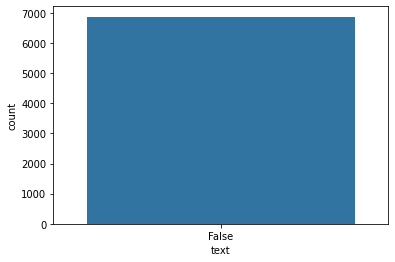

In [6]:
sns.countplot((tot["text"] == None))

Sapendo che "id" è la nostra colonna primaria, controllo che il numero di valori unici nella colonna primaria sia uguale al numero di righe. Questo mi permette di accertarmi di non avere la stessa riga per più di una volta nel mio dataset.

In [7]:
tot['id'].nunique() == len(tot['id'])

False

In [8]:
tot = tot.drop_duplicates(subset="id", keep='last')
tot = tot.drop_duplicates(subset="text", keep='last')

for index, row in tot.iterrows():  
  try:
    trashId = row['id']
    trash = row['text'].lower()
  except AttributeError as ae:
    tot.drop(tot[tot['id'] == trashId].index, inplace=True)

In [9]:
tot['id'].nunique() == len(tot['id'])

True

In [10]:
tot=tot.reset_index(drop=True)

In [11]:
tot.count()

culture    6053
music      6053
food       6053
fun        6053
id         6053
text       6053
dtype: int64

###**A1**: *PLOT DEL DATASET*

In [24]:
def getRandomIndex(df):
  return random.randint(0, len(df) - 1)

getRandomIndex(tot)

4948

Ecco i primi elementi del dataset.

In [12]:
tot.head()

,culture,music,food,fun,id,text
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se..."
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...


In [13]:
tot.dtypes

culture     int64
music       int64
food        int64
fun         int64
id          int64
text       object
dtype: object

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


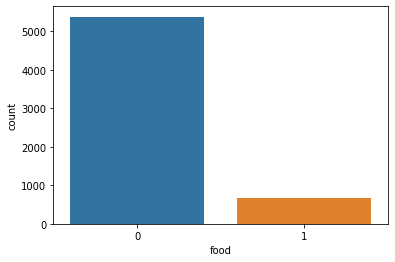

In [14]:
sns.countplot(tot['food'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


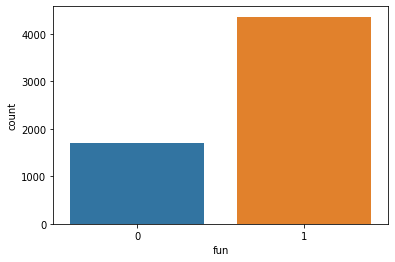

In [15]:
sns.countplot(tot['fun'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


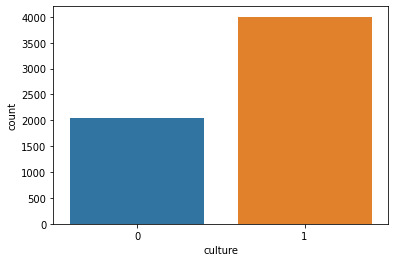

In [16]:
sns.countplot(tot['culture'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


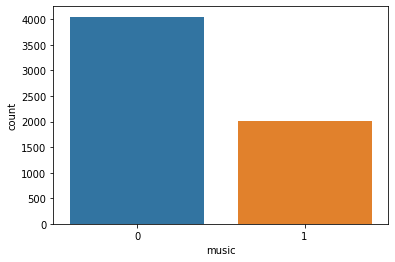

In [17]:
sns.countplot(tot['music'])

##**B**: *PREPROCESS DELLE DESCRIZIONI*

###**B1**: *FUNZIONI PREPROCESSING*

In [53]:
def remove_numbers(input_string):
    # Crea una tabella di traduzione che mappa tutti i numeri a None
    translate_table = input_string.maketrans("", "", string.digits)
    # Utilizza la tabella di traduzione per rimuovere tutti i numeri
    return input_string.translate(translate_table)

def remove_punctuation(input_string):
    for char in string.punctuation:
          input_string = input_string.replace(char, " ")
    return input_string

stnzPipe = stanza.Pipeline(lang='it', processors='tokenize,pos')

def remove_non_N_V(input_string):
    words = tkn(input_string)
    doc = stnzPipe(' '.join(words))
    tagged_words = [word.text for sent in doc.sentences for word in sent.words if word.upos in ['NOUN', 'VERB']]
    return ' '.join(tagged_words)

def preProcessDescription(description, stopwordsTotali, maxSeqLen = None,tokenizer = None):
  words = remove_non_N_V(remove_punctuation(remove_numbers(description.lower()))).split()

  parole_filtrate = [parola for parola in words if not parola in stopwordsTotali]
 
  descrizione_filtrata = " ".join(parole_filtrate)
  if (maxSeqLen is None or tokenizer is None):
    input_data = descrizione_filtrata
  else:
    # convert the text to a numerical representation
    input_data = tokenizer.texts_to_sequences([descrizione_filtrata])
    input_data = pad_sequences(input_data, maxlen=maxSeqLen,padding='post')
    original_description = ""
    for i, word in enumerate(input_data[0]):
      if word == 1:
        for key, value in tokenizer.word_index.items():
          if value == i :
            original_description += key + " "
    print('Traduzione della sequenza numero in parole: ')
    print(original_description)
  return input_data

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: it (Italian):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| pos       | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Done loading processors!


Wordnet Ontology Functions

In [19]:
#Wordnet

def get_syns(description):
  test=[]
  words = tkn(description)
  for every in words:
    if (every not in stopwordsTotali):
      if(wn.synsets(every, lang ='ita') == []):
        
          test.append(wn.synsets(every))
      else:
        
          test.append(wn.synsets(every, lang ='ita'))
      #print('parola iniziale: ',every)
      #print('synset: ',wn.synsets(every, lang ='ita'))
  lemmatizer = WordNetLemmatizer()
  out =[]
  for each in range(len(test)):
    for q in range(len(test[each])):
      wordToAdd=lemmatizer.lemmatize(test[each][q].name().split('.')[0])
      out.append(wordToAdd)
      if(q==1):
        #print(out)
        break
  #out=test
  out=list(set(out))
  return out

def reduced_description(description):
    # Tokenize the description
    tokens = tkn(description)
    # Reduce the words to their most common synset
    reduced_description = []
    for token in tokens:
      try:
          synset = wn.synsets(token, lang='ita',pos=wn.NOUN)
         
          
          lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
          reduced_description.append(lemma)
      except:
        try:
          synset = wn.synsets(token, lang='ita',pos=wn.VERB)
          lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
          reduced_description.append(lemma)
        except:
          try:
            synset = wn.synsets(token, lang='eng',pos=wn.NOUN)
            lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
            reduced_description.append(lemma)
          except:
            try:
                synset = wn.synsets(token, lang='eng',pos=wn.VERB)
                lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
                reduced_description.append(lemma)
            except:
    
                continue
   
    return list(set(reduced_description))


def predict_closest_clusters(df, description, km, X, vectorizerTfIdf):

    description=get_syns(description)

    newWords = ''
    
    for each in description:
      newWords = newWords + ' ' + each
    description=newWords

    # Transform the input description into a tf-idf representation
    input_tfidf = vectorizerTfIdf.transform([description])

    # Calculate the distances between the input and each of the 10 clusters
    cluster_distances = km.transform(input_tfidf).flatten()

    # Get the index of the closest cluster
    closest_cluster_index = np.argmin(cluster_distances)

    print("Il cluster più vicino è il cluster numero: ", closest_cluster_index)

    terms = vectorizerTfIdf.get_feature_names()
    top_ten_words = [terms[ind] for ind in order_centroids[closest_cluster_index, :5]]
    print("Le sue parole più rilevanti sono: {}".format(', '.join(top_ten_words)))
    
    # Calculate the distances between the input and each sample in X
    sample_distances = pairwise_distances(input_tfidf, X).flatten()
    # Get the indices of the 5 closest samples
    closest_sample_indices = sample_distances.argsort()
    print("I 5 eventi più importanti nel dataset sono:")
    count = 0
    for i in closest_sample_indices: 
      if (len(df['text'][i]) > 100):
        print(df['text'][i])
        count = count + 1
      if (count == 5):
        break

###**B2**: *PREPROCESSING*

In [20]:
stp = open("/content/drive/MyDrive/Colab Notebooks/stopwordsita.txt", "r")
data = stp.read().split("\n")
stp.close()
stopwordsTotali = stopwords.words('italian') + stopwords.words('english') + data
stopwordsTotali = list(set(stopwordsTotali).union(['il', 'lo', 'la', 'i', 'gli', 'le', 'una', 'un', 'uno', 'di', 'a', 'da', 'in', 'con', 'su', 'per', 'tra', 'fra', 'www', 'http', 'https', 'it','com']))

In [58]:
descrizioni_filtrate = []
for index, evento in tot.iterrows():
  descrizione_filtrata=preProcessDescription(evento['text'],stopwordsTotali)
  descrizioni_filtrate.append(descrizione_filtrata)

KeyboardInterrupt: ignored

In [ ]:
np.savetxt('/content/drive/MyDrive/Colab Notebooks/descrizioni_filtrate.txt', np.array(descrizioni_filtrate), fmt='%s')

#descrizioni_filtrate_loaded = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/descrizioni_filtrate.txt', dtype=str)

In [27]:
ix = getRandomIndex(tot)
print(descrizioni_filtrate[ix])
print('\n\n')
print(tot['text'][ix])

risolvi crittogramma scoprire spettacolo fantastico premio prima pubblichera soluzione commenti aggiudichera biglietto omaggio spettacolo risolverlo bisogna ricordare ogni numero corrisponde lettera dellalfabeto corrisponde lettera scoprire quattro risolvi definizione



Risolvi il crittogramma per scoprire la sinossi dello spettacolo e vincere un fantastico premio: la persona che per prima pubblichera la soluzione nei commenti, si aggiudichera un biglietto omaggio per lo spettacolo. Per risolverlo, bisogna ricordare che ad ogni numero corrisponde una lettera dellalfabeto e che a numero uguale corrisponde lettera uguale. Per scoprire le prime quattro lettere, risolvi la definizione.


In [57]:
doc = stnzPipe('bello')
doc.sentences[0].words[0].upos

'ADJ'

In [ ]:
corpus = descrizioni_filtrate

In [ ]:
type(corpus)

In [ ]:
print(len(tot['text']) == len(corpus))

In [ ]:
tot['filtered_desc']=corpus

In [ ]:
X1 = []
newText=corpus

for description in newText:   
    feature =[]
    features = reduced_description(str(description))
    words = ''
    for each in features:
      words = words + ' ' + each
    X1.append(words)

In [ ]:
tot['wordnet_desc']=X1

In [ ]:
inx=7
print(corpus[inx])
print(X1[inx])

In [ ]:
tot

###**B3**: *TOKENIZATION, SEQUENCING & PADDING*

In [ ]:
MAX_NB_WORDS = 30000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
seq_lens = [len(s) for s in sequences]

In [ ]:
sampleIndex = 1998
print('Sequenza parola numero %s: ' % sampleIndex)
for x in sequences[sampleIndex]:
  print('%d,' % x, end =' ')

In [ ]:
print('Traduzione della sequenza numero %d in parole: ' % sampleIndex)
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[sampleIndex]])

In [ ]:
%matplotlib inline

plt.hist(seq_lens, bins=500, color = 'purple')
plt.xlabel('#words')
plt.ylabel('#descriptions')
plt.title('Y documenti con X parole')

In [ ]:
media=np.mean(seq_lens)
print("average length: %0.1f" % media)
print("max length: %d" % max(seq_lens))
y = 0
for i in seq_lens:
  if i < media:
    y = y + 1

print("percentuale descrizioni di lunghezza inferiore ad average length: %d%%" % (int(y*100/len(seq_lens))))


La lunghezza media dei testi è di circa 65: eseguo il pad con massima lunghezza 70, valutando che la maggior parte delle descrizioni non supera quel numero di parole.

In [ ]:
MAX_SEQUENCE_LENGTH = 70

# pad sequences with 0s
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

print('Shape of data tensor:', padded.shape)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [ ]:
padded[sampleIndex].shape[0]

In [ ]:
preProcessDescription('techno rave party festa scuola',stopwordsTotali, MAX_SEQUENCE_LENGTH, tokenizer)

###**B4**: *RAPPRESENTAZIONE DEL TESTO A BASSO LIVELLO*

####**B4.1**: *ALTERNATIVA EMBEDDINGS VIA WORLD2VEC*


In [ ]:
# Download the models (1660MB)
word2vec_model300 = api.load('word2vec-google-news-300')

In [ ]:
word2vec_model300.save("/content/drive/MyDrive/Colab Notebooks/word2vec.bin")

In [ ]:
'''
x_emb = []
for sentence in padded:
  print('sentence')
  print(sentence)
  sent_emb = [0 for k in range(300)] 
  
  num_tok = 0
  for tok in sentence:
    if tok != 0:
      word=list(word_index.keys())[list(word_index.values()).index(tok)]
      print('word: '+ word)
      try:
          emb = word2vec_model300.wv[word]
          sent_emb = [x + y for x, y in zip(sent_emb, emb)]
          num_tok = num_tok +1
      except:
          pass
  if num_tok != 0:
    final_sent_emb = [x / num_tok for x in sent_emb]         
  x_emb.append(final_sent_emb)
  

x_emb = np.array(x_emb)
with open('/content/drive/MyDrive/Colab Notebooks/embeddings.npy', 'wb') as f:
    np.save(f, x_emb)
'''
with open('/content/drive/MyDrive/Colab Notebooks/embeddings.npy', 'rb') as f:
    x_emb = np.load(f)
print(type(x_emb))
print(x_emb.shape)


In [ ]:
x_emb.shape

In [ ]:
print(x_emb[sampleIndex])

####**B4.2**: *ALTERNATIVA FEATURE EXTRACTION VIA RETE NEURALE*

In [ ]:
embedding_size = 1000

# Creare la rete neurale feed-forward
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creare la matrice di vettorizzazione delle descrizioni degli eventi
#POTREI PROVARE CON "CORPUS" AL POSTO DI PADDINGS
token_matrix = model.predict(padded)

####**B4.3**: *ALTERNATIVA VECTORIZATION VIA TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY*

In [ ]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(corpus)

##**C**: *CLASSIFICAZIONE*

In [ ]:
y = tot[['culture', 'music', 'food', 'fun']]

####Split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
X_trainEmb,X_testEmb,y_trainEmb,y_testEmb = train_test_split(x_emb,y,test_size=0.25,random_state=42)

In [ ]:
X_trainTM,X_testTM,y_trainTM,y_testTM = train_test_split(token_matrix,y,test_size=0.25,random_state=42)

###Pesi

In [ ]:
weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)
weightsEmb = class_weight.compute_sample_weight(class_weight="balanced", y=y_trainEmb)
weightsTM = class_weight.compute_sample_weight(class_weight="balanced", y=y_trainTM)

In [ ]:
print(weights==weightsEmb)
print(weightsEmb==weightsTM)

In [ ]:

pca = PCA (170)

reduced = pca.fit_transform(x_emb)

X_reduced,X_testReduced,y_trainReduced,y_testReduced = train_test_split(reduced,y,test_size=0.25,random_state=42)
reduced.shape

###Classificazione

Ora utilizzeremo la tecnica di classificazione a multipli riferimenti (OneVsRest) in quanto il nostro dataset risulta sbilanciato. È buona norma utilizzare questo tipo di classificazione sui dataset sbilanciati perché si addestra un classificatore per ogni classe: ogni classificatore è responsabile della distinzione tra la sua classe specifica e tutte le altre (appunto One vs Rest). Questo significa che ogni classificatore può concentrarsi sulle proprietà distintive della classe stessa

In [ ]:
classificatori = [OneVsRestClassifier, ClassifierChain, LabelPowerset]
estimatori =[DecisionTreeClassifier(),RandomForestClassifier(), SVC()]
#prova anche uno fra logistic reg e sdgclassifier
param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None, 5, 10],
    'estimator__min_samples_split': [2, 10],
    'estimator__min_samples_leaf': [1, 4]
}

In [ ]:
def atlas (estimatori, classificatori, x_train, x_test, y_train, y_test, parametri = None):
  results = []
  for ml in classificatori:
    for each in estimatori:
      clf = ml(each)
      if (parametri is None):
          clf.fit(x_train, y_train)
          y_pred = clf.predict(x_test)
      else:
        try:
          grid_search = GridSearchCV(clf, parametri, cv=5, scoring='accuracy')
          grid_search.fit(x_train, y_train)
          best_clf = grid_search.best_estimator_
          y_pred = best_clf.predict(x_test)
        except:
          clf.fit(x_train, y_train)
          y_pred = clf.predict(x_test)
      print('\n\n')
      print(str(ml) + ' con ' + str(each) + ':\n\n')
      try:
        print('Accuracy: %0.5f' % accuracy_score(y_test,y_pred))
      except:
        try:
          print('Accuracy: %0.5f' % accuracy_score(y_test,y_pred.toarray()))
        except:
          print('skip')
          continue
      try:
        print('Loss di hamming: %0.5f' % hamming_loss(y_test,y_pred))
      except:
        try:
          print('Loss di hamming: %0.5f' % hamming_loss(y_test,y_pred.toarray()))
        except:
          print('skip')
          continue
      try:
        print('Label ranking Average-Precision: %0.5f' % label_ranking_average_precision_score(y_test,y_pred))
      except:
        try:
          print('Label ranking Average-Precision: %0.5f' % label_ranking_average_precision_score(y_test,y_pred.toarray()))
        except:
          print('skip')
          continue
      results.append([str(ml), str(each), y_pred])
  return results

In [ ]:
print('Eseguo classificazione su Embeddings (Word2Vec)\n')
risultatiEmb = atlas(estimatori, classificatori, X_trainEmb, X_testEmb, y_trainEmb, y_testEmb, param_grid)

In [ ]:
print('Eseguo classificazione su matrice di token (feature Neural Network)\n')
risultatiNN = atlas(estimatori, classificatori, X_trainTM, X_testTM, y_trainTM, y_testTM, param_grid)

In [ ]:
print('Eseguo classificazione su vettori Tf-Idf\n')
risultatiTfIdf = atlas(estimatori, classificatori, X_train, X_test, y_train, y_test, param_grid)

####VariousPlots

In [ ]:
print(risultatiTfIdf[0][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[0][1], zero_division=1, output_dict=True, target_names=['culture', 'music','food','fun'])).iloc[:-1, :].T, annot=True, linecolor='purple')

In [ ]:
print(results[1][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[1][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

In [ ]:
print(results[2][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[2][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

In [ ]:
print(results[3][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[3][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

In [ ]:
print(results[4][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[4][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

###Trasformazione del dataset in valori discreti (rivedere)

Abbiamo dimostrato che, approssimativamente, il LabelPowerset con Support Vector Machine sia la combinazione migliore nell'ambito dei tentativi effettuati. Procediamo con il trasformare il dataset in valori discreti (da 0 a 1)

In [ ]:
# Define target variables
target_variables = ["culture", "music", "food", "fun"]

# Fit a LabelPowerset model with an SVC base estimator for each target variable
models = []
for target in target_variables:
    clf = LabelPowerset(classifier=SVC(random_state=0))
    clf.fit(X, tot[target])
    models.append(clf)

# Generate probability estimates for each target variable
probabilities = np.zeros((tot.shape[0], len(target_variables)))
for i, clf in enumerate(models):
    probabilities[:, i] = clf.predict_proba(vectorizer.transform(tot["filtered_desc"])).toarray()[:, 1]

# Normalize the probabilities so that they sum up to 1 for each sample
probabilities /= probabilities.sum(axis=1, keepdims=True)

# Create a new dataset with the probabilities
new_df = pd.DataFrame(probabilities, columns=target_variables)

# Add descriptions as new columns
new_df["filtered_desc"] = tot["filtered_desc"]
new_df["wordnet_desc"] = tot["wordnet_desc"]
new_df["text"] = tot["text"]
new_df["id"] = tot["id"].astype(str)

# Save the new dataset
# new_df.to_csv("probabilities.csv", index=False)




OROROROROROROROROROR

In [ ]:
target_variables = ["culture", "music", "food", "fun"]

# Fit a logistic regression model for each target variable
models = []
for target in target_variables:
    clf = LogisticRegression(random_state=0)
    clf.fit(X, tot[target])
    models.append(clf)

# Generate probability estimates for each target variable
probabilities = np.zeros((tot.shape[0], len(target_variables)))
for i, clf in enumerate(models):
    probabilities[:, i] = clf.predict_proba(vectorizer.fit_transform(tot["filtered_desc"]))[:, 1]

# Normalize the probabilities so that they sum up to 1 for each sample
probabilities /= probabilities.sum(axis=1, keepdims=True)

# Creare un nuovo dataset con le probabilità
new_df = pd.DataFrame(probabilities, columns=target_variables)

# Aggiungere le descrizioni come nuova colonna
new_df["filtered_desc"] = tot["filtered_desc"]
new_df["wordnet_desc"] = tot["wordnet_desc"]
new_df["text"] = tot["text"]
new_df["id"]=tot["id"].astype(str)
# Salvare il nuovo dataset
#new_df.to_csv("probabilities.csv", index=False)

In [ ]:
new_df

In [ ]:
tot

In [ ]:
new_event = ['Techno rave musica ballo amici alcohol']
X_new = vectorizer.transform(new_event)

y_pred = [clf.predict_proba(X_new).toarray()[0][1] for clf in models]

# Compare the results to determine the event's class membership
pred_class = target_variables[np.argmax(y_pred)]
print(f"The new event belongs to the {pred_class} class with a probability of {np.max(y_pred):.2f}")

OROROROROROROROROR

In [ ]:
# Prevedi le etichette per un nuovo evento
#_____________________________________________
# Importantissimo: questo funziona per la logistic regression
#_____________________________________________
new_event = ['Techno rave musica ballo amici alcohol']
X_new = vectorizer.transform(new_event)

y_pred_fun = models[0].predict_proba(X_new)[0][1]
y_pred_food = models[1].predict_proba(X_new)[0][1]
y_pred_culture = models[2].predict_proba(X_new)[0][1]
y_pred_music = models[3].predict_proba(X_new)[0][1]

# Confronta i risultati per evincere la categoria di appartenenza dell'evento
probs = [y_pred_fun, y_pred_food, y_pred_culture, y_pred_music]
pred_class = ['culture', 'music', 'food', 'fun'][np.argmax(probs)]
print(f"The new event belongs to the {pred_class} class with a probability of {np.max(probs):.2f}")

##**D**: *RETE NEURALE*

In [ ]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

# get the model
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(256, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
  return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X_train, y_train, X_test, y_test):
  results = list()
  # define evaluation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  model = get_model(X_train.shape[1], y_train.shape[1])
  # fit model
  fit=model.fit(X_train, y_train, verbose=1, epochs=50)
  # make a prediction on the test set
  yhat = model.predict(X_test)
    # calculate accuracy
  acc = accuracy_score(y_test.round(), yhat.round())
  # store result
  print('>%.3f' % acc)
  results.append(acc)
  print(yhat)
  return results,model

In [ ]:
# evaluate model
results,model = evaluate_model(X_train, y_train, X_test, y_test)
# summarize performance
print('Accuracy tfidf: %.3f (%.3f)' % (mean(results), std(results)))

# evaluate model
resultsTM,modelTM = evaluate_model(X_trainTM, y_trainTM, X_testTM, y_testTM)
# summarize performance
print('Accuracy matrice di token NN: %.3f (%.3f)' % (mean(resultsTM), std(resultsTM)))

# evaluate model
resultsEmb,modelEmb = evaluate_model(X_trainEmb, y_trainEmb, X_testEmb, y_testEmb)
# summarize performance
print('Accuracy Embeddings word2vec: %.3f (%.3f)' % (mean(resultsEmb), std(resultsEmb)))

##**E**: *LOGICHE FUZZY*

Vogliamo tramite regole fuzzy determinare se un evento si svolgerà di notte o meno

In [ ]:

from skfuzzy import control as ctrl
from fuzzywuzzy import fuzz

In [ ]:
def is_night_event(event_vector, night_vector, threshold=25):
  similarity = fuzz.token_set_ratio(event_vector, night_vector)
  if similarity >= threshold:
    return True
  else:
    return False

Deduco la costruzione della regola da delle stime probabilistiche effettuate sul dataset

In [ ]:
def categorize_text(df, string):
  words = string.split()
  result = [0, 0, 0, 0]
  count = 0
  for index, row in tot.iterrows():
    for word in words:
      if word in row['text']:
        result[0] = result[0] + row['fun']
        result[1] = result[1] + row['food']
        result[2] = result[2] + row['culture']
        result[3] = result[3] + row['music']
        count = count + 1
        break
  result[0] = result[0] / count
  result[1] = result[1] / count
  result[2] = result[2] / count
  result[3] = result[3] / count
  return result
#questi rappresentano i valori medi su cui definiremo la regola
valoriNotte=categorize_text(tot,'notte')
valoriNotte

estrae il vettore delle feature per quell'evento

In [ ]:
def get_event_vector(event_tuple):
    event_vector = []
    for header in ['fun', 'food', 'culture', 'music']:
        event_vector.append(event_tuple[header])
    return event_vector

In [ ]:
event_vector=get_event_vector(new_df.iloc[0])
event_vector

In [ ]:
result = is_night_event(event_vector, valoriNotte)
if result:
  print("L'evento è di notte")
else:
  print("L'evento non è di notte")

In [ ]:
tag=[]
for index, row in new_df.iterrows():
    event_vector=get_event_vector(new_df.iloc[index])
    tag.append(is_night_event(event_vector, valoriNotte))

new_df['atNight'] = tag

In [ ]:
new_df

##**F**: *RAPPRESENTAZIONE DELLA CONOSCENZA*

###**F1**: *ONTOLOGIA: WORDNET*

In [ ]:
vectorizerTfIdf=TfidfVectorizer()
vectorTfIdf=vectorizerTfIdf.fit_transform(new_df['wordnet_desc'])
#X_train1, X_test1 = train_test_split(vectorTfIdf, test_size=0.2, random_state=42) 

In [ ]:
number_of_clusters=10
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(vectorTfIdf)

In [ ]:
# But you could fit the idf_df instea
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizerTfIdf.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [ ]:
cluster_labels=km.labels_
len(cluster_labels)

In [ ]:
descrizione='pizza pasta mandolino'
predict_closest_clusters(new_df, descrizione, km, vectorTfIdf, vectorizerTfIdf)

In [ ]:
labels=km.labels_
cluster_labels = np.unique(labels)
cluster_sizes = [(labels == c).sum() for c in cluster_labels]
sizes_idx = np.argsort(cluster_sizes)[::-1][:5]
X1=new_df['wordnet_desc']
# Plot dei risultati
for i, c in enumerate(cluster_labels[sizes_idx]):
    mask = (labels == c)
    descrizioni_c = np.array(X1)[mask]
    text = " ".join(descrizioni_c)
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwordsTotali, 
                min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)

##CNN

In [ ]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def content_based_recommendation(event_index, content_matrix, num_recommendations):
    similarity = np.zeros(content_matrix.shape[0])
    for i in range(len(similarity)):
        similarity[i] = cosine_similarity(content_matrix[event_index], content_matrix[i])

    recommendation_indices = np.argsort(similarity)[::-1][1:num_recommendations+1]
    return recommendation_indices

In [ ]:
num_events = new_df.shape[0]
num_recommendations = 5
recommendation_matrix = np.zeros((num_events, num_recommendations), dtype=int)
content_columns = ["culture", "music", "food", "fun"]
content_matrix = new_df[content_columns].values
for i in range(num_events):
    recommended_indices = content_based_recommendation(i, content_matrix, num_recommendations)
    recommendation_matrix[i, :] = recommended_indices

#np.savetxt("recommendation_matrix.csv", recommendation_matrix, delimiter=",", fmt='%d')
recommendation_matrix

In [ ]:
print('EVENTO PRESO IN ESAME: ')
print(new_df['text'][1000])
count = 1
for each in recommendation_matrix[1000]:
  print('EVENTO CONSIGLIATO NUMERO ' + str(count) + ': ')
  print(new_df['text'][each])
  print('\n\n')
  count = count + 1